# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).


In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import namedtuple
from agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [6]:
GreedyPolicy = namedtuple('GreedyPolicy', ('start', 'end', 'decay'))
SCORE_WINDOW_SIZE = 400  # window size over which scores will be averaged
SCORE_CUTOFF = 16.0      # average cutoff score to win an episode

def train_agent(agent, n_episodes=2000, max_t=1000, policy=GreedyPolicy(1.0, 0.01, 0.995)):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []
    scores_window = deque(maxlen=SCORE_WINDOW_SIZE)
    epsilon = policy.start
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0

        for t in range(max_t):
            action = agent.act(state, epsilon)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        scores.append(score)
        epsilon = max(policy.end, policy.decay * epsilon)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % SCORE_WINDOW_SIZE == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window) >= SCORE_CUTOFF:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - SCORE_WINDOW_SIZE, np.mean(scores_window)))
            break

    return scores

In [7]:
CHECKPOINT_FILE = 'checkpoint.pth'
agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size, seed=0)

Episode 400	Average Score: 6.03
Episode 800	Average Score: 14.46
Episode 1112	Average Score: 16.00
Environment solved in 712 episodes!	Average Score: 16.00


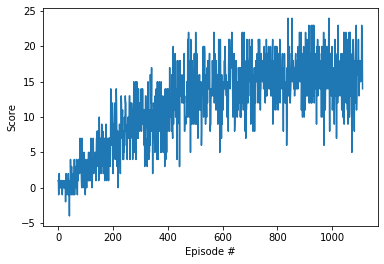

In [8]:
try:
    scores = train_agent(agent)
finally:
    torch.save(agent.qnetwork.state_dict(), CHECKPOINT_FILE)
    env.reset()[brain_name]

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Check the agent in action

In [9]:
agent.qnetwork.load_state_dict(torch.load(CHECKPOINT_FILE))

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0

    for j in range(500):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward

        print(f"\rScore: {score}", end="")
        if done:
            break 
    print("")


Score: 15.0
Score: 21.0
Score: 15.0


In [10]:
env.close()